# 带注解的光标

显示包含文本框的数据光标，该文本框显示鼠标指针附近的绘图点。

新的光标继承自 {class}`~matplotlib.widgets.Cursor`，并展示了如何创建新的小部件及其事件回调。

另请参见十字准线光标，它实现了跟踪绘图数据的光标功能，但不使用继承且不显示当前跟踪的坐标。

```{note}
与此示例相关的图形不显示光标，因为该图形是自动在构建队列中创建的，而触发光标创建的第一次鼠标移动缺失了。
```

In [1]:
%matplotlib inline

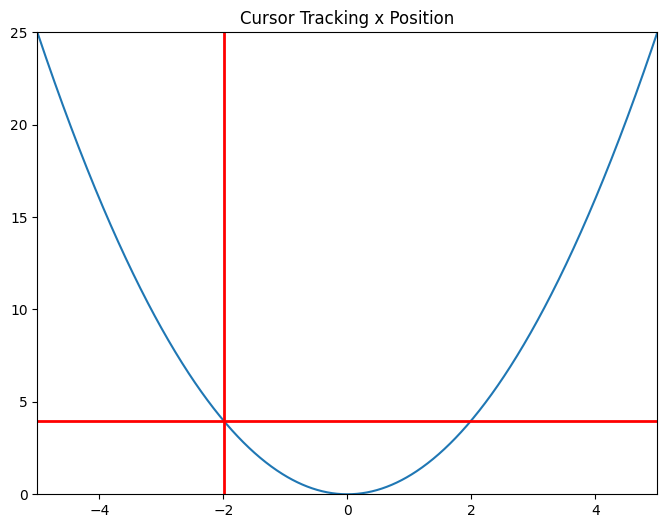

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.backend_bases import MouseEvent
from matplotlib.widgets import Cursor


class AnnotatedCursor(Cursor):
    """
    A crosshair cursor like `~matplotlib.widgets.Cursor` with a text showing \
    the current coordinates.

    For the cursor to remain responsive you must keep a reference to it.
    The data of the axis specified as *dataaxis* must be in ascending
    order. Otherwise, the `numpy.searchsorted` call might fail and the text
    disappears. You can satisfy the requirement by sorting the data you plot.
    Usually the data is already sorted (if it was created e.g. using
    `numpy.linspace`), but e.g. scatter plots might cause this problem.
    The cursor sticks to the plotted line.

    Parameters
    ----------
    line : `matplotlib.lines.Line2D`
        The plot line from which the data coordinates are displayed.

    numberformat : `python format string <https://docs.python.org/3/\
    library/string.html#formatstrings>`_, optional, default: "{0:.4g};{1:.4g}"
        The displayed text is created by calling *format()* on this string
        with the two coordinates.

    offset : (float, float) default: (5, 5)
        The offset in display (pixel) coordinates of the text position
        relative to the cross-hair.

    dataaxis : {"x", "y"}, optional, default: "x"
        If "x" is specified, the vertical cursor line sticks to the mouse
        pointer. The horizontal cursor line sticks to *line*
        at that x value. The text shows the data coordinates of *line*
        at the pointed x value. If you specify "y", it works in the opposite
        manner. But: For the "y" value, where the mouse points to, there might
        be multiple matching x values, if the plotted function is not biunique.
        Cursor and text coordinate will always refer to only one x value.
        So if you use the parameter value "y", ensure that your function is
        biunique.

    Other Parameters
    ----------------
    textprops : `matplotlib.text` properties as dictionary
        Specifies the appearance of the rendered text object.

    **cursorargs : `matplotlib.widgets.Cursor` properties
        Arguments passed to the internal `~matplotlib.widgets.Cursor` instance.
        The `matplotlib.axes.Axes` argument is mandatory! The parameter
        *useblit* can be set to *True* in order to achieve faster rendering.

    """

    def __init__(self, line, numberformat="{0:.4g};{1:.4g}", offset=(5, 5),
                 dataaxis='x', textprops=None, **cursorargs):
        if textprops is None:
            textprops = {}
        # The line object, for which the coordinates are displayed
        self.line = line
        # The format string, on which .format() is called for creating the text
        self.numberformat = numberformat
        # Text position offset
        self.offset = np.array(offset)
        # The axis in which the cursor position is looked up
        self.dataaxis = dataaxis

        # First call baseclass constructor.
        # Draws cursor and remembers background for blitting.
        # Saves ax as class attribute.
        super().__init__(**cursorargs)

        # Default value for position of text.
        self.set_position(self.line.get_xdata()[0], self.line.get_ydata()[0])
        # Create invisible animated text
        self.text = self.ax.text(
            self.ax.get_xbound()[0],
            self.ax.get_ybound()[0],
            "0, 0",
            animated=bool(self.useblit),
            visible=False, **textprops)
        # The position at which the cursor was last drawn
        self.lastdrawnplotpoint = None

    def onmove(self, event):
        """
        Overridden draw callback for cursor. Called when moving the mouse.
        """

        # Leave method under the same conditions as in overridden method
        if self.ignore(event):
            self.lastdrawnplotpoint = None
            return
        if not self.canvas.widgetlock.available(self):
            self.lastdrawnplotpoint = None
            return

        # If the mouse left drawable area, we now make the text invisible.
        # Baseclass will redraw complete canvas after, which makes both text
        # and cursor disappear.
        if event.inaxes != self.ax:
            self.lastdrawnplotpoint = None
            self.text.set_visible(False)
            super().onmove(event)
            return

        # Get the coordinates, which should be displayed as text,
        # if the event coordinates are valid.
        plotpoint = None
        if event.xdata is not None and event.ydata is not None:
            # Get plot point related to current x position.
            # These coordinates are displayed in text.
            plotpoint = self.set_position(event.xdata, event.ydata)
            # Modify event, such that the cursor is displayed on the
            # plotted line, not at the mouse pointer,
            # if the returned plot point is valid
            if plotpoint is not None:
                event.xdata = plotpoint[0]
                event.ydata = plotpoint[1]

        # If the plotpoint is given, compare to last drawn plotpoint and
        # return if they are the same.
        # Skip even the call of the base class, because this would restore the
        # background, draw the cursor lines and would leave us the job to
        # re-draw the text.
        if plotpoint is not None and plotpoint == self.lastdrawnplotpoint:
            return

        # Baseclass redraws canvas and cursor. Due to blitting,
        # the added text is removed in this call, because the
        # background is redrawn.
        super().onmove(event)

        # Check if the display of text is still necessary.
        # If not, just return.
        # This behaviour is also cloned from the base class.
        if not self.get_active() or not self.visible:
            return

        # Draw the widget, if event coordinates are valid.
        if plotpoint is not None:
            # Update position and displayed text.
            # Position: Where the event occurred.
            # Text: Determined by set_position() method earlier
            # Position is transformed to pixel coordinates,
            # an offset is added there and this is transformed back.
            temp = [event.xdata, event.ydata]
            temp = self.ax.transData.transform(temp)
            temp = temp + self.offset
            temp = self.ax.transData.inverted().transform(temp)
            self.text.set_position(temp)
            self.text.set_text(self.numberformat.format(*plotpoint))
            self.text.set_visible(self.visible)

            # Tell base class, that we have drawn something.
            # Baseclass needs to know, that it needs to restore a clean
            # background, if the cursor leaves our figure context.
            self.needclear = True

            # Remember the recently drawn cursor position, so events for the
            # same position (mouse moves slightly between two plot points)
            # can be skipped
            self.lastdrawnplotpoint = plotpoint
        # otherwise, make text invisible
        else:
            self.text.set_visible(False)

        # Draw changes. Cannot use _update method of baseclass,
        # because it would first restore the background, which
        # is done already and is not necessary.
        if self.useblit:
            self.ax.draw_artist(self.text)
            self.canvas.blit(self.ax.bbox)
        else:
            # If blitting is deactivated, the overridden _update call made
            # by the base class immediately returned.
            # We still have to draw the changes.
            self.canvas.draw_idle()

    def set_position(self, xpos, ypos):
        """
        Finds the coordinates, which have to be shown in text.

        The behaviour depends on the *dataaxis* attribute. Function looks
        up the matching plot coordinate for the given mouse position.

        Parameters
        ----------
        xpos : float
            The current x position of the cursor in data coordinates.
            Important if *dataaxis* is set to 'x'.
        ypos : float
            The current y position of the cursor in data coordinates.
            Important if *dataaxis* is set to 'y'.

        Returns
        -------
        ret : {2D array-like, None}
            The coordinates which should be displayed.
            *None* is the fallback value.
        """

        # Get plot line data
        xdata = self.line.get_xdata()
        ydata = self.line.get_ydata()

        # The dataaxis attribute decides, in which axis we look up which cursor
        # coordinate.
        if self.dataaxis == 'x':
            pos = xpos
            data = xdata
            lim = self.ax.get_xlim()
        elif self.dataaxis == 'y':
            pos = ypos
            data = ydata
            lim = self.ax.get_ylim()
        else:
            raise ValueError(f"The data axis specifier {self.dataaxis} should "
                             f"be 'x' or 'y'")

        # If position is valid and in valid plot data range.
        if pos is not None and lim[0] <= pos <= lim[-1]:
            # Find closest x value in sorted x vector.
            # This requires the plotted data to be sorted.
            index = np.searchsorted(data, pos)
            # Return none, if this index is out of range.
            if index < 0 or index >= len(data):
                return None
            # Return plot point as tuple.
            return (xdata[index], ydata[index])

        # Return none if there is no good related point for this x position.
        return None

    def clear(self, event):
        """
        Overridden clear callback for cursor, called before drawing the figure.
        """

        # The base class saves the clean background for blitting.
        # Text and cursor are invisible,
        # until the first mouse move event occurs.
        super().clear(event)
        if self.ignore(event):
            return
        self.text.set_visible(False)

    def _update(self):
        """
        Overridden method for either blitting or drawing the widget canvas.

        Passes call to base class if blitting is activated, only.
        In other cases, one draw_idle call is enough, which is placed
        explicitly in this class (see *onmove()*).
        In that case, `~matplotlib.widgets.Cursor` is not supposed to draw
        something using this method.
        """

        if self.useblit:
            super()._update()


fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Cursor Tracking x Position")

x = np.linspace(-5, 5, 1000)
y = x**2

line, = ax.plot(x, y)
ax.set_xlim(-5, 5)
ax.set_ylim(0, 25)

# A minimum call
# Set useblit=True on most backends for enhanced performance
# and pass the ax parameter to the Cursor base class.
# cursor = AnnotatedCursor(line=lin[0], ax=ax, useblit=True)

# A more advanced call. Properties for text and lines are passed.
# Watch the passed color names and the color of cursor line and text, to
# relate the passed options to graphical elements.
# The dataaxis parameter is still the default.
cursor = AnnotatedCursor(
    line=line,
    numberformat="{0:.2f}\n{1:.2f}",
    dataaxis='x', offset=[10, 10],
    textprops={'color': 'blue', 'fontweight': 'bold'},
    ax=ax,
    useblit=True,
    color='red',
    linewidth=2)

# Simulate a mouse move to (-2, 10), needed for online docs
t = ax.transData
MouseEvent(
    "motion_notify_event", ax.figure.canvas, *t.transform((-2, 10))
)._process()

plt.show()

## 非双射函数的问题'

这个示例展示了 `dataaxis=y` 参数的问题。文本现在查找与当前光标 `y` 位置匹配的 `x` 值，而不是相反。将鼠标悬停在 `y=4` 上。有两个 `x` 值产生这个 `y` 值：`-2` 和 `2`。函数是唯一的，但不是双射的。文本中只显示一个值。

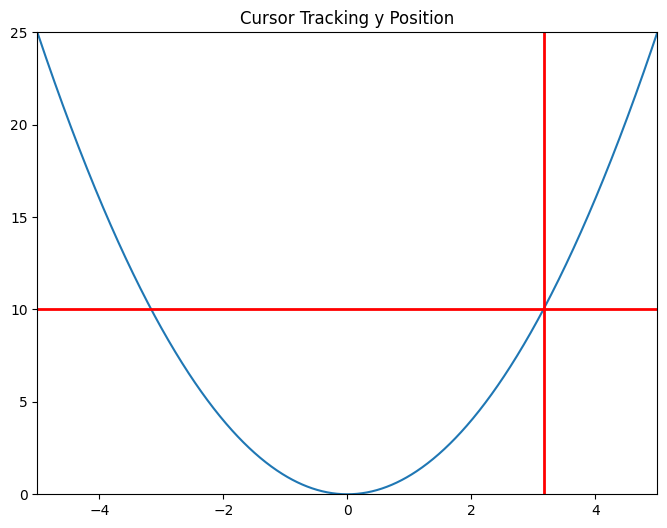

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Cursor Tracking y Position")

line, = ax.plot(x, y)
ax.set_xlim(-5, 5)
ax.set_ylim(0, 25)

cursor = AnnotatedCursor(
    line=line,
    numberformat="{0:.2f}\n{1:.2f}",
    dataaxis='y', offset=[10, 10],
    textprops={'color': 'blue', 'fontweight': 'bold'},
    ax=ax,
    useblit=True,
    color='red', linewidth=2)

# Simulate a mouse move to (-2, 10), needed for online docs
t = ax.transData
MouseEvent(
    "motion_notify_event", ax.figure.canvas, *t.transform((-2, 10))
)._process()

plt.show()